Put `coveval` folder into our path for easy import of modules:

In [1]:
import sys
sys.path.append('../')

# Load data

In [2]:
from coveval import utils
from coveval.connectors import generic

Let's load some data corresponding to the state of New-York and look at the number of daily fatalities:

In [3]:
df_reported = utils.get_outbreak_data_usa(prefix='reported_').loc['US-NY']
df_predicted = generic.load_predictions('../data/demo/predictions.json', prefix='predicted_')
data = utils.add_outbreak_data(df_predicted, df_reported)[['reported_deathIncrease', 'predicted_incDeath']]

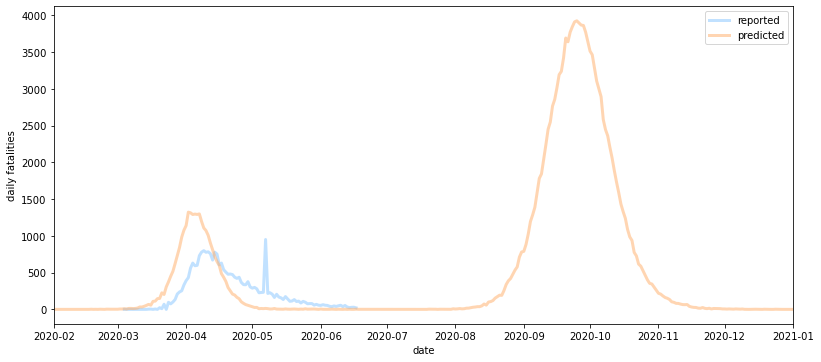

In [4]:
_ = utils.show_data(df=data,
                    cols=['reported_deathIncrease', 'predicted_incDeath'],
                    t_min='2020-02',
                    t_max='2021-01',
                    colors={'cols':{'reported_deathIncrease': '#85C5FF', 'predicted_incDeath': '#FFAD66'}},
                    linewidths={'reported_deathIncrease': 3, 'predicted_incDeath': 3},
                    show_leg={'reported_deathIncrease': 'reported', 'predicted_incDeath': 'predicted'},
                    y_label='daily fatalities',
                    x_label='date',
                    figsize=(11,5))

# Smooth reported values

In [5]:
from coveval.core import smoothing

We want to smooth out noise in the reported data due to reporting errors and delays. To do so we can use for instance the "missed case" smoother.

And it's also useful to smooth out high frequency noise in the predictions made by stochastc models as they do not correspond to a useful signal and pollute trend comparisons. A simple low-pass filter can be appropriate here.

In [7]:
# define smoothers
smoothers = {'missed': smoothing.missed_cases(cost_missing=.1, cost_der1=10, cost_der2=1),
             'gaussian': smoothing.gaussian(sigma=2)}

# smooth reported data
col = 'reported_deathIncrease'
s_name = 'missed'
smoothers[s_name].smooth_df(data, col, inplace=True)
data.rename(columns={col + '_smoothed' : col + '_smoothed_' + s_name}, inplace=True)

# smooth predictions
col = 'predicted_incDeath'
s_name = 'gaussian'
smoothers[s_name].smooth_df(data, col, inplace=True)
data.rename(columns={col + '_smoothed' : col + '_smoothed_' + s_name}, inplace=True)

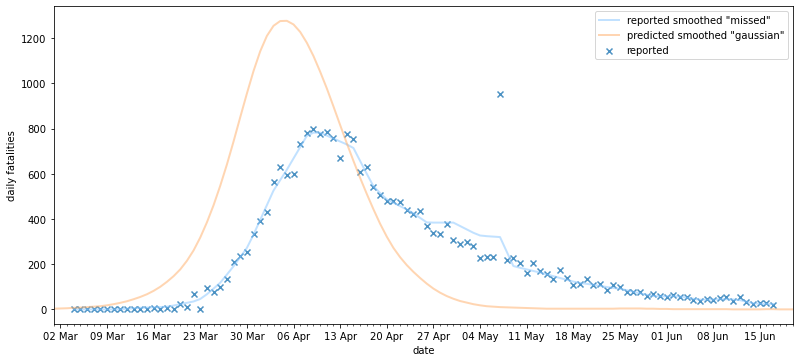

In [8]:
_ = utils.show_data(data,
                cols=['reported_deathIncrease_smoothed_missed','predicted_incDeath_smoothed_gaussian'],
                scatter=['reported_deathIncrease'],
                colors={'cols':{'reported_deathIncrease_smoothed_missed': '#85C5FF',
                                'predicted_incDeath_smoothed_gaussian': '#FFAD66'}},
                date_auto=False,
                t_min='2020-03',
                t_max='2020-06-20',
                show_leg={'reported_deathIncrease': 'reported',
                          'reported_deathIncrease_smoothed_missed': 'reported smoothed "missed"',
                          'predicted_incDeath_smoothed_gaussian': 'predicted smoothed "gaussian"'},
                y_label='daily fatalities',
                x_label='date',
                figsize=(11,5))

# Normalise predicted values

In [9]:
from coveval.core import normalising

The goal here is to avoid repeatedly punishing predictions made by a model due to e.g. the model getting the start of the outbreak wrong.

In [11]:
normaliser_scaling = normalising.dynamic_scaling()
normaliser_scaling.normalise_df(df=data,
                                col_truth='reported_deathIncrease_smoothed_missed',
                                col_pred='predicted_incDeath_smoothed_gaussian',
                                inplace=True)

# let's store the difference between the truth and the normalised predictions
data['predicted_incDeath_smoothed_gaussian_norm_match'] = data['reported_deathIncrease_smoothed_missed'] - data['predicted_incDeath_smoothed_gaussian_norm']

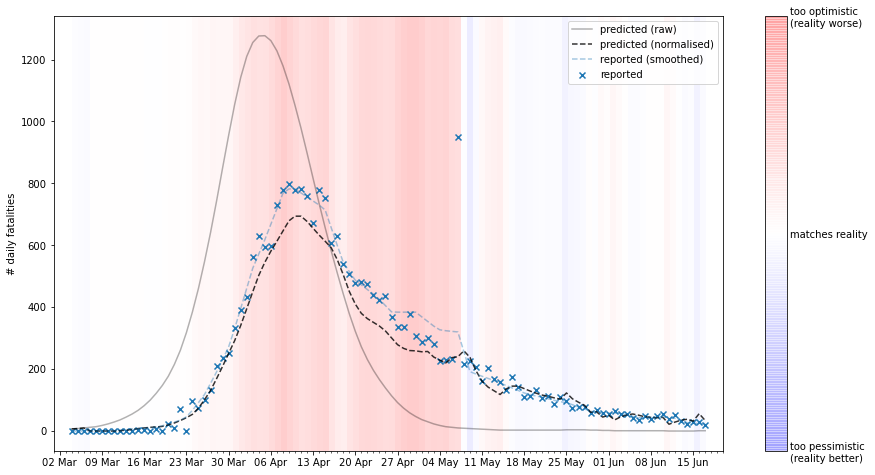

In [12]:
fig = utils.show_normalisation(data,
                               truth='reported_deathIncrease',
                               pred_raw='predicted_incDeath_smoothed_gaussian',
                               pred_norm='predicted_incDeath_smoothed_gaussian_norm',
                               pred_match='predicted_incDeath_smoothed_gaussian_norm_match',
                               truth_smoothed='reported_deathIncrease_smoothed_missed')

# Compare to truth

In [13]:
from coveval.core import losses

Now we can use a simple Poisson loss to judge how well each normalised prediction compares to the reported data and compute an overall score that can be compared with that of other models.

In [14]:
poisson_loss = losses.poisson()
poisson_loss.compute_df(df=data,
                        col_truth='reported_deathIncrease_smoothed_missed',
                        col_pred='predicted_incDeath_smoothed_gaussian_norm',
                        inplace=True)
data['predicted_incDeath_smoothed_gaussian_norm_loss'].mean()

4.650568702737793

# All in one: scorer

In [15]:
from coveval.scoring import scorer

The scorer object performes the above operations in a single call - with the exception of smoothing the predictions as for some models this is not necessary.

In [16]:
default_scorer = scorer(smoother=smoothers['missed'],
                        normaliser=normaliser_scaling,
                        loss=poisson_loss)
results = default_scorer.score_df(df=data,
                                  col_truth='reported_deathIncrease',
                                  col_pred='predicted_incDeath_smoothed_gaussian')

In [32]:
# the average loss is the score (so the closer to 0 the better)
results['score']

4.650568702737793